# LSTM example with multivariate time series
- the feature matrix consists of lags of the target signal and lags of other features
- keras LSTM model is used to forecast the target signal
- for info on the dataset used and the methodology see: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- it uses a data generator for train/valid/test data
    - this will help for large time-series datasets with many features that can cause memory problems
- don't need to add lags to dataframe; the generator will take care of it
- if you want lagged aggregation, just use add columns with pandas' rolling() and mean() or other agg method
- the model was trained on a free GPU from https://colab.research.google.com
    - LSTMs don't get the same kind of training acceleration from GPUs as CNNs (and LSTMs can even run slower on GPUs)
    - However this notebook uses CuDNNLSTM layers which provide accelerated preformance on GPUs
* `TODO`: replace generator function with new  **keras.preprocessing.sequence.TimeseriesGenerator**

# Import Dependencies

In [0]:
#from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## Read pollution.csv into pandas df
- set date as index
- display first 5 rows
- the Air Pollution data is discussed here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- this is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.
- we can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

In [81]:
df = pd.read_csv('https://raw.githubusercontent.com/sagarmk/Forecasting-on-Air-pollution-with-RNN-LSTM/master/pollution.csv',index_col=0)

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [82]:
print('number of rows = ', df.shape[0])

number of rows =  43800


## Plot the data
- for this step, we'll use the same code used here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

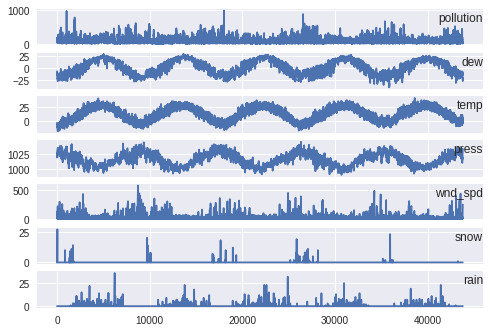

In [83]:
# specify columns to plot
values = df.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## One-hot-encode ['wnd_dir'] column
- wind_dir column is categorical
- use pd.get_dummies to preform this on pandas dataframe

In [84]:
list(df['wnd_dir'].unique())

['SE', 'cv', 'NW', 'NE']

In [85]:
df.groupby('wnd_dir')['wnd_dir'].count()

wnd_dir
NE     4996
NW    14130
SE    15290
cv     9384
Name: wnd_dir, dtype: int64

In [0]:
df = pd.concat([df,pd.get_dummies(df['wnd_dir'], prefix='wnd_dir')],axis=1)
df.drop(['wnd_dir'],axis=1, inplace=True)

In [87]:
df.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


## we'll drop the date index
- there's no missing timestamps, so we won't be needing it

In [0]:
df = df.reset_index(drop=True)

## Split the Data
- split the data sequentially mainting chronological order
- split 80/20 training/test
    - we will split-off a validation set from the training set later

In [0]:
df_train = df.loc[:int(df.shape[0]*0.8),:]
df_test = df.loc[int(df.shape[0]*0.8):,:]

## Plot the train/test split

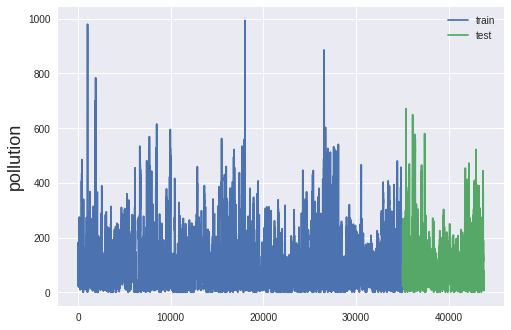

In [90]:
plt.plot(df_train.index,df_train['pollution'])
plt.plot(df_test.index,df_test['pollution'])
plt.ylabel('pollution',fontsize=18)
plt.legend(['train','test'])
plt.show()

## Normalize the Data
- for available scalers see: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- becareful of outliers when scaling!
- perform the normalization on the pandas dataframe

In [92]:
df_train_norm = df_train.copy()
df_test_norm = df_test.copy()

scaler = MinMaxScaler(feature_range=(0, 1))
df_train_norm.loc[:,:'rain']  = scaler.fit_transform(df_train.loc[:,:'rain'])
df_test_norm.loc[:,:'rain']  = scaler.fit_transform(df_test.loc[:,:'rain'])

df_train_norm.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,0.129779,0.278689,0.250000,0.527273,0.002290,0.000000,0.0,0,0,1,0
1,0.148893,0.295082,0.250000,0.527273,0.003811,0.000000,0.0,0,0,1,0
2,0.159960,0.360656,0.233333,0.545455,0.005332,0.000000,0.0,0,0,1,0
3,0.182093,0.426230,0.233333,0.563636,0.008391,0.037037,0.0,0,0,1,0
4,0.138833,0.426230,0.233333,0.563636,0.009912,0.074074,0.0,0,0,1,0


## Use a data generator
- creates batches on the fly
- good for data with large number of rows and features
- don't need to perform lags on dataframe
- the function below was adapted from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- note: Keras added a TimeseriesGenerator class in version 2.1.5 
    - https://github.com/keras-team/keras/releases/tag/2.1.5
    - keras.preprocessing.sequence.TimeseriesGenerator
keras.preprocessing.sequence.TimeseriesGenerator
It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `dataframe`: pandas dataframe with feature matrix and target column
* `target_name`: string of column with target values
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [0]:
def generator(dataframe, target_name, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    
    data = dataframe.values
    data = data.astype(np.float32)
    target_indx = df.columns.get_loc(target_name)
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_indx]
        yield samples, targets

## create train, validation, test data generators
- we will 20% of the df_train to get the validation generator
    - use the min_index,max_index arguments for slices from generator function

In [0]:
#use previous 450 samples to predict next target ('pollution') samples
lookback = 450 # window used for prediction
delay = 1 # predict target one step ahead
batch_size = 256

train_gen = generator(dataframe = df_train_norm, 
                      target_name = 'pollution', 
                      lookback = lookback,
                      delay = 1,
                      min_index = 0,
                      max_index = int(df_train.shape[0]*0.8),
                      step = 1,
                      shuffle = True,
                      batch_size = batch_size)

valid_gen = generator(dataframe = df_train_norm, 
                      target_name = 'pollution', 
                      lookback = lookback,
                      delay = 1,
                      min_index = int(df_train.shape[0]*0.8),
                      max_index = None,
                      step = 1,
                      shuffle = False,
                      batch_size = batch_size)

# test_gen = generator(dataframe = df_test, 
#                      target_name = 'pollution', 
#                      lookback = lookback,
#                      delay = 1,
#                      min_index = 0,
#                      max_index = None,
#                      step = 1,
#                      shuffle = False,
#                      batch_size = batch_size)

In [117]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = int((df_train_norm.shape[0]*.1 - lookback) // batch_size)
print('validation_steps = ', val_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
train_steps = int((df_train_norm.shape[0]*.9 - lookback) // batch_size)
print('train_steps = ', train_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
test_steps = int((df_test_norm.shape[0] - lookback) // batch_size)
print('test_steps = ', test_steps)

validation_steps =  11
train_steps =  121
test_steps =  32


In [0]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Create LSTM model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU
- can also use lightwieght GRU layers

In [0]:
model = Sequential()
# model.add(LSTM(50,
#                activation='relu',
#                return_sequences=True,
#                stateful=False,
#                input_shape=(None, df_train.shape[1])))
# model.add(LSTM(50,
#              activation='relu',
#              return_sequences=False,
#              stateful=False))

model.add(CuDNNLSTM(64,
               return_sequences=True,
               stateful=False,
               input_shape=(None, df_train_norm.shape[1])))
model.add(CuDNNLSTM(32,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(16,
             return_sequences=False,
             stateful=False))
#model.add(Dropout(0.4))

model.add(Dense(1))

## Fit the Model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU

In [120]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0, patience=4),
             ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='mae', optimizer='adam',metrics=[r2_keras])
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=100,
                              shuffle=False,
                              validation_data=valid_gen,
                              validation_steps=val_steps,
                              callbacks = callbacks)

Epoch 1/100
121/121 [==============================] - 22s 180ms/step - loss: 0.0453 - r2_keras: 0.4901 - val_loss: 0.0298 - val_r2_keras: 0.4302
Epoch 2/100
121/121 [==============================] - 20s 166ms/step - loss: 0.0357 - r2_keras: 0.6518 - val_loss: 0.0267 - val_r2_keras: 0.6231
Epoch 3/100
121/121 [==============================] - 20s 167ms/step - loss: 0.0289 - r2_keras: 0.7603 - val_loss: 0.0240 - val_r2_keras: 0.7037
Epoch 4/100
121/121 [==============================] - 20s 167ms/step - loss: 0.0259 - r2_keras: 0.8019 - val_loss: 0.0199 - val_r2_keras: 0.6603
Epoch 5/100
121/121 [==============================] - 20s 166ms/step - loss: 0.0229 - r2_keras: 0.8267 - val_loss: 0.0221 - val_r2_keras: 0.7786
Epoch 6/100
121/121 [==============================] - 20s 166ms/step - loss: 0.0217 - r2_keras: 0.8357 - val_loss: 0.0186 - val_r2_keras: 0.6464
Epoch 7/100
121/121 [==============================] - 20s 167ms/step - loss: 0.0218 - r2_keras: 0.8269 - val_loss: 0.0202 -

## Get model predictions on df_test
- get (X,y_truth) by calling train_gen using next
- set the batch_size

In [121]:
df_test_norm.shape[0]

8760

In [0]:
test_gen = generator(dataframe = df_test_norm, 
                     target_name = 'pollution', 
                     lookback = lookback,
                     delay = 1,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test.shape[0])

In [123]:
(X, y_truth) = next(test_gen)

y_pred = model.predict(X)


print('X_shape = ',X.shape)
print('y_truth = ',y_truth.shape)
print('y_pred = ',y_pred.shape)

X_shape =  (8308, 450, 11)
y_truth =  (8308,)
y_pred =  (8308, 1)


In [124]:
np.expand_dims(y_truth,axis=1).shape

(8308, 1)

### Need to remove normalization
- since we preformed normlization transform on 7 cols of dataframe, we need to add dummy colums to preds

In [0]:
y_pred = np.concatenate((y_pred,np.zeros((y_pred.shape[0],6))),axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

y_truth = np.concatenate((np.expand_dims(y_truth,axis=1),np.zeros((y_truth.shape[0],6))),axis=1)
y_truth = scaler.inverse_transform(y_truth)
y_truth = y_truth[:,0]

### Get R2 for this prediction

In [126]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred,y=y_truth)
print('R2 = ',r_value*r_value)

R2 =  0.8771529854688266


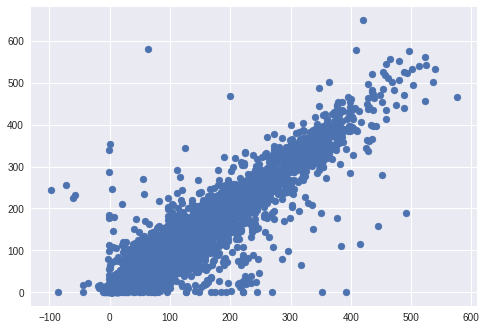

In [127]:
plt.scatter(x=y_pred,y=y_truth)

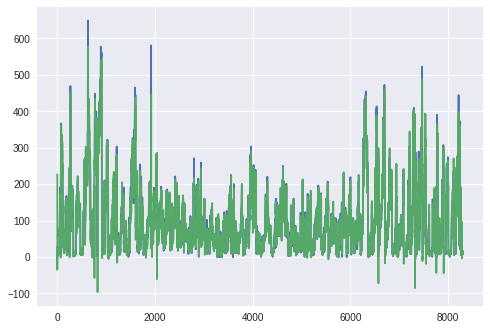

In [128]:
plt.plot(y_truth)
plt.plot(y_pred)
plt.show()

## Let's try the evaluate_generator in keras

In [129]:
(_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)
print('R2 = ',r2)

R2 =  0.8759715557098389
